# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
Updating files:  33% (1902/5717)
Updating files:  34% (1944/5717)
Updating files:  35% (2001/5717)
Updating files:  36% (2059/5717)
Updating files:  37% (2116/5717)
Updating files:  38% (2173/5717)
Updating files:  39% (2230/5717)
Updating files:  40% (2287/5717)
Updating files:  41% (2344/5717)
Updating files:  42% (2402/5717)
Updating files:  43% (2459/5717)
Updating files:  44% (2516/5717)
Updating files:  45% (2573/5717)
Updating files:  46% (2630/5717)
Updating files:  47% (2687/5717)
Updating files:  48% (2745/5717)
Updating files:  49% (2802/5717)
Updating files:  50% (2859/5717)
Updating files:  51% (2916/5717)
Updating files:  52% (2973/5717)
Updating files:  53% (3031/5717)
Updating files:  54% (3088/5717)
Updating files:  55% (3145/5717)
Updating files:  56% (3202/5717)
Updating files:  57% (3259/5717)
Updating files:  58% (3316/5717)
Updating files:  59% (3374/5717)
Updating files:  60% (3431/5717)
Updating files:  61% (3488/5717)
Updat

In [1]:
import torch
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## PART I: Constructing Model
To tackle this problem, we have to note the low number of training data. With such few training samples, the model is very prone to overfitting. To reduce the effect of overfitting we take two approaches:
1. Using regularization techniques: Dropout and Weight Decay.
2. Employing light-weight models with fewer parameters. High-parameter models tend to overfit to training data if the number of samples is not adequete.

In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15):
    """
    Trains a given model using the provided training and validation data loaders.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimization algorithm.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        num_epochs (int, optional): Number of epochs to train the model. Default is 15.

    Returns:
        tuple: A tuple containing four lists:
            - train_loss (list): Training loss for each epoch.
            - val_loss (list): Validation loss for each epoch.
            - train_acc (list): Training accuracy for each epoch.
            - val_acc (list): Validation accuracy for each epoch.
    """

    # storing metrics for later evaluations
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Accuracy: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                x, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    return model, train_loss, val_loss, train_acc, val_acc

#### Model Choice:

To avoid overfitting, we will use a lightweight model. The model will have a feature extractor part, and a classification part. 
The feature extractor a feature vector of size 256 * 4 * 4 which will later be passed to the classification model. The majority of model learnable parameters will be in the classificiation section.

In [6]:
class LightNet(nn.Module):
    def __init__(self, num_classes=43):
        super(LightNet, self).__init__()
        # Feature extractor part
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),     
            
        )
        
        # Classifier part
        self.classifier = nn.Sequential(
            nn.Flatten(),                               # Flatten the output of conv layers
            nn.Linear(256 * 4 * 4, 256),                # Fully connected layer 1
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),               # Fully connected layer 1
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),               # Final layer with output for each class
        )
        
    def forward(self, x):
        x = self.features(x)                           # Pass the input through the feature extractor
        x = self.classifier(x)                         # Then through the classifier
        return x
    

    
net = LightNet().to(device)
summary(net, (3,128,128))

d:\codebox\virtual_env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
              ReLU-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,928
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

#### Data Loader
To further address the problem of overfitting on low number of training data, we will use `RandomHorizontalFlip` and `RandomRotation` augmentations. We will also normalize the data to have a mean of 0 and variance of 1 for better convergance.

In [7]:
transform_train = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.5306, 0.3964, 0.2564], std=[0.2252, 0.2018, 0.1704])
    ])

transform_val = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=[0.5045, 0.3970, 0.2805], std=[0.2350, 0.2108, 0.1837])
    ])

# Create Datasets
train_dataset = GroceryStoreDataset(split='train', transform=transform_train)
val_dataset = GroceryStoreDataset(split='val', transform=transform_val)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [61]:
# Function to compute mean and std dev
def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in loader:
        image_count_in_batch = images.size(0)
        images = images.view(image_count_in_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_batch

    mean /= total_images_count
    std /= total_images_count

    print(f"Mean: {mean}")
    print(f"Std Dev: {std}")
    return mean, std

mean, std = compute_mean_std(val_dataloader)

Mean: tensor([2.0029e-04, 1.3339e-04, 7.4119e-05])
Std Dev: tensor([1.0000, 0.9999, 0.9998])


In [10]:
def report_metrics(train_acc, val_acc):
    plt.style.use('dark_background')
    print(f"Best Validation Score: {max(val_acc)}")
    # Plotting the accuracies and losses
    plt.figure(figsize=(14, 7))
    
    n_epochs = len(train_acc)
    # Plot accuracy
    plt.plot(range(n_epochs), train_acc, label='Training Accuracy')
    plt.plot(range(n_epochs), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

### Training Strategy
We will train the model in a number of steps, in each step we will decrease the `learning rate` to catch more details in training data, and increase `weight_decay` to avoid overfitting and closing the gap between training and validation.

In [11]:
total_val_acc = []
total_train_acc = []

In [12]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 20

# first training step
net, train_loss, val_loss, train_acc, val_acc = train_model(net, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)


# second training step
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.003)
num_epochs = 50

net, train_loss, val_loss, train_acc, val_acc = train_model(net, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)

# third training step
optimizer = torch.optim.SGD(net.parameters(), lr=0.0008, weight_decay=0.005)
num_epochs = 20

net, train_loss, val_loss, train_acc, val_acc = train_model(net, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)

# fourth training step
optimizer = torch.optim.SGD(net.parameters(), lr=0.0008, weight_decay=0.01)
num_epochs = 20

net, train_loss, val_loss, train_acc, val_acc = train_model(net, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)

d:\codebox\virtual_env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/20], Batch [0/83], Loss: 3.7442, Accuracy: 0.0625
Epoch [1/20], Batch [10/83], Loss: 3.6821, Accuracy: 0.0710
Epoch [1/20], Batch [20/83], Loss: 3.6458, Accuracy: 0.0699
Epoch [1/20], Batch [30/83], Loss: 3.6085, Accuracy: 0.0847
Epoch [1/20], Batch [40/83], Loss: 3.5601, Accuracy: 0.1029
Epoch [1/20], Batch [50/83], Loss: 3.5157, Accuracy: 0.1103
Epoch [1/20], Batch [60/83], Loss: 3.4759, Accuracy: 0.1230
Epoch [1/20], Batch [70/83], Loss: 3.4396, Accuracy: 0.1329
Epoch [1/20], Batch [80/83], Loss: 3.4164, Accuracy: 0.1385
Epoch [1/20] Train Loss: 3.4158, Train Acc: 0.1398, Val Loss: 3.2090, Val Acc: 0.1892
Epoch [2/20], Batch [0/83], Loss: 3.2134, Accuracy: 0.2188
Epoch [2/20], Batch [10/83], Loss: 3.0854, Accuracy: 0.2045
Epoch [2/20], Batch [20/83], Loss: 3.1231, Accuracy: 0.1979
Epoch [2/20], Batch [30/83], Loss: 3.1138, Accuracy: 0.1915
Epoch [2/20], Batch [40/83], Loss: 3.0990, Accuracy: 0.1936
Epoch [2/20], Batch [50/83], Loss: 3.0695, Accuracy: 0.1949
Epoch [2/20], Ba

Best Validation Score: 0.625


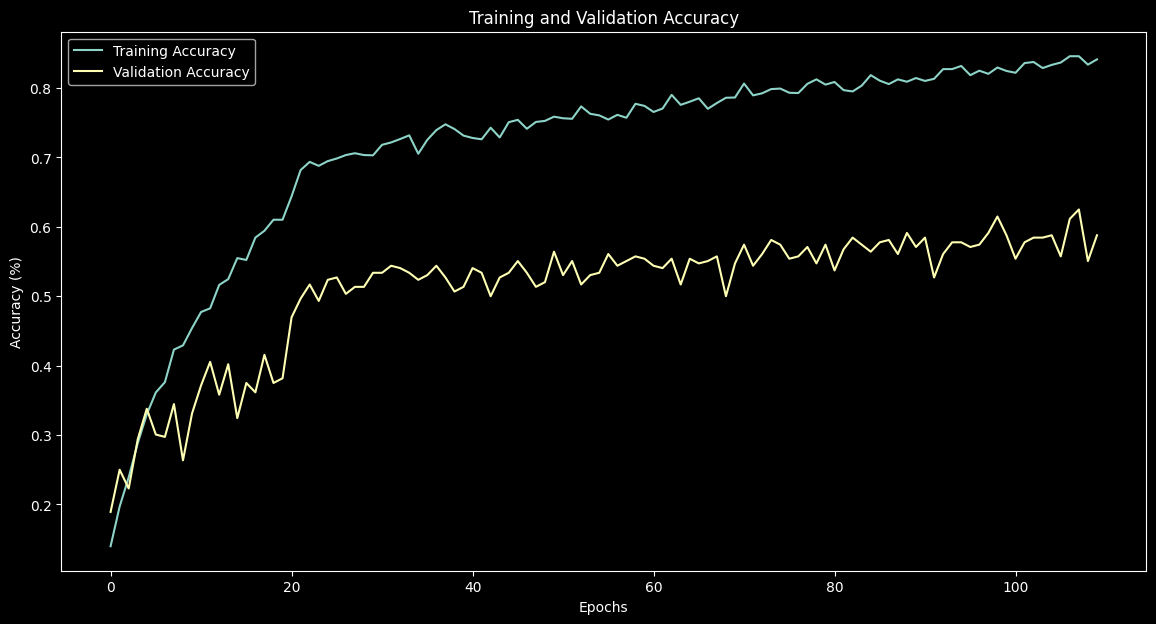

In [15]:
report_metrics(total_train_acc, total_val_acc)

In [16]:
torch.save(net.state_dict(), 'LightNet625.pth')

We will also evalute if the model will perform as well, using ADAM optimizer

In [17]:
net_adam = LightNet().to(device)


optimizer = torch.optim.Adam(net_adam.parameters(), lr=0.01, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 20

# first training step
net_adam, train_loss, val_loss, train_acc, val_acc = train_model(net_adam, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)

# second training step
optimizer = torch.optim.Adam(net_adam.parameters(), lr=0.001, weight_decay=0.003)
num_epochs = 50

net_adam, train_loss, val_loss, train_acc, val_acc = train_model(net_adam, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)


# third training step
optimizer = torch.optim.Adam(net_adam.parameters(), lr=0.0008, weight_decay=0.005)
num_epochs = 20

net_adam, train_loss, val_loss, train_acc, val_acc = train_model(net_adam, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)

# fourth training step
optimizer = torch.optim.Adam(net_adam.parameters(), lr=0.0008, weight_decay=0.01)
num_epochs = 20

net_adam, train_loss, val_loss, train_acc, val_acc = train_model(net_adam, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)

Epoch [1/20], Batch [0/83], Loss: 3.8060, Accuracy: 0.0000
Epoch [1/20], Batch [10/83], Loss: 10.2827, Accuracy: 0.0625
Epoch [1/20], Batch [20/83], Loss: 7.1485, Accuracy: 0.0744
Epoch [1/20], Batch [30/83], Loss: 6.0108, Accuracy: 0.0877
Epoch [1/20], Batch [40/83], Loss: 5.4107, Accuracy: 0.0892
Epoch [1/20], Batch [50/83], Loss: 5.0575, Accuracy: 0.0907
Epoch [1/20], Batch [60/83], Loss: 4.7779, Accuracy: 0.0948
Epoch [1/20], Batch [70/83], Loss: 4.6004, Accuracy: 0.0942
Epoch [1/20], Batch [80/83], Loss: 4.4414, Accuracy: 0.0988
Epoch [1/20] Train Loss: 4.4184, Train Acc: 0.1008, Val Loss: 3.3424, Val Acc: 0.1486
Epoch [2/20], Batch [0/83], Loss: 3.3518, Accuracy: 0.0625
Epoch [2/20], Batch [10/83], Loss: 3.3771, Accuracy: 0.0710
Epoch [2/20], Batch [20/83], Loss: 3.3480, Accuracy: 0.0833
Epoch [2/20], Batch [30/83], Loss: 3.3715, Accuracy: 0.0938
Epoch [2/20], Batch [40/83], Loss: 3.3462, Accuracy: 0.1098
Epoch [2/20], Batch [50/83], Loss: 3.3592, Accuracy: 0.1115
Epoch [2/20], B

Looking at the training results of Adam, we can see the val_acc did not go above 52%, by far performing worse than SGD in this use case.

Now that we have established a smaller net is what we need for low number of training data, we will increase the training parameters a bit to test if the model will perform better.

In [18]:
class TestNet(nn.Module):
    def __init__(self, num_classes=43):
        super(TestNet, self).__init__()
        # Feature extractor part
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),     
            
        )
        
        # Classifier part
        self.classifier = nn.Sequential(
            nn.Flatten(),                               # Flatten the output of conv layers
            nn.Linear(256 * 4 * 4, 512),                # Fully connected layer 1
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),               # Fully connected layer 1
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),               # Final layer with output for each class
        )
        
    def forward(self, x):
        x = self.features(x)                           # Pass the input through the feature extractor
        x = self.classifier(x)                         # Then through the classifier
        return x
    

    
test_net = TestNet().to(device)
summary(test_net, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              ReLU-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]         147,584
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]         147,584
      BatchNorm2d-14          [-1, 128,

In [19]:
total_val_acc = []
total_train_acc = []
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(test_net.parameters(), lr=0.01, weight_decay=0.001)
num_epochs = 20

# first training step
test_net, train_loss, val_loss, train_acc, val_acc = train_model(test_net, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)


# second training step
optimizer = torch.optim.SGD(test_net.parameters(), lr=0.001, weight_decay=0.003)
num_epochs = 50

test_net, train_loss, val_loss, train_acc, val_acc = train_model(test_net, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)

# third training step
optimizer = torch.optim.SGD(test_net.parameters(), lr=0.0008, weight_decay=0.005)
num_epochs = 20

test_net, train_loss, val_loss, train_acc, val_acc = train_model(test_net, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)

# fourth training step
optimizer = torch.optim.SGD(test_net.parameters(), lr=0.0008, weight_decay=0.01)
num_epochs = 20

test_net, train_loss, val_loss, train_acc, val_acc = train_model(test_net, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)

Epoch [1/20], Batch [0/83], Loss: 3.8454, Accuracy: 0.0312
Epoch [1/20], Batch [10/83], Loss: 3.7417, Accuracy: 0.0455
Epoch [1/20], Batch [20/83], Loss: 3.6920, Accuracy: 0.0699
Epoch [1/20], Batch [30/83], Loss: 3.6290, Accuracy: 0.0796
Epoch [1/20], Batch [40/83], Loss: 3.5752, Accuracy: 0.0953
Epoch [1/20], Batch [50/83], Loss: 3.5351, Accuracy: 0.1054
Epoch [1/20], Batch [60/83], Loss: 3.4978, Accuracy: 0.1122
Epoch [1/20], Batch [70/83], Loss: 3.4569, Accuracy: 0.1224
Epoch [1/20], Batch [80/83], Loss: 3.4150, Accuracy: 0.1277
Epoch [1/20] Train Loss: 3.4102, Train Acc: 0.1284, Val Loss: 3.2300, Val Acc: 0.1791
Epoch [2/20], Batch [0/83], Loss: 3.0814, Accuracy: 0.2500
Epoch [2/20], Batch [10/83], Loss: 3.1548, Accuracy: 0.2017
Epoch [2/20], Batch [20/83], Loss: 3.0951, Accuracy: 0.1949
Epoch [2/20], Batch [30/83], Loss: 3.0993, Accuracy: 0.1915
Epoch [2/20], Batch [40/83], Loss: 3.0794, Accuracy: 0.1890
Epoch [2/20], Batch [50/83], Loss: 3.0511, Accuracy: 0.1906
Epoch [2/20], Ba

Best Validation Score: 0.6486486486486487


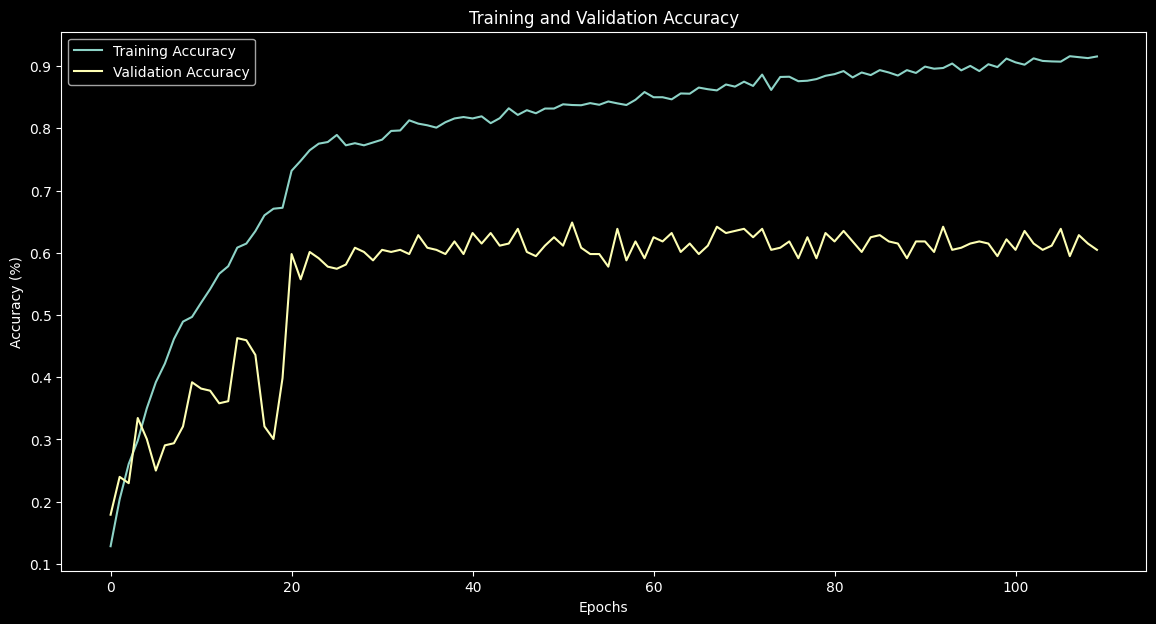

In [20]:
report_metrics(total_train_acc, total_val_acc)

In [23]:
torch.save(test_net.state_dict(), 'TestNet648.pth')

Now let's test a new test model and see if it performs better with more parameters.

In [28]:
class TestNet2(nn.Module):
    def __init__(self, num_classes=43):
        super(TestNet2, self).__init__()
        # Feature extractor part
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),     
            
        )
        
        # Classifier part
        self.classifier = nn.Sequential(
            nn.Flatten(),                               # Flatten the output of conv layers
            nn.Linear(512 * 4 * 4, 256),                # Fully connected layer 1
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),               # Fully connected layer 1
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),               # Final layer with output for each class
        )
        
    def forward(self, x):
        x = self.features(x)                           # Pass the input through the feature extractor
        x = self.classifier(x)                         # Then through the classifier
        return x
    

    
test_net2 = TestNet2().to(device)
summary(test_net2, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              ReLU-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]         147,584
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

In [29]:
total_val_acc = []
total_train_acc = []
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(test_net2.parameters(), lr=0.01, weight_decay=0.001)
num_epochs = 20

# first training step
test_net2, train_loss, val_loss, train_acc, val_acc = train_model(test_net2, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)


# second training step
optimizer = torch.optim.SGD(test_net2.parameters(), lr=0.001, weight_decay=0.003)
num_epochs = 50

test_net2, train_loss, val_loss, train_acc, val_acc = train_model(test_net2, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)

# third training step
optimizer = torch.optim.SGD(test_net2.parameters(), lr=0.0008, weight_decay=0.005)
num_epochs = 20

test_net2, train_loss, val_loss, train_acc, val_acc = train_model(test_net2, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)

# fourth training step
optimizer = torch.optim.SGD(test_net2.parameters(), lr=0.0008, weight_decay=0.01)
num_epochs = 20

test_net2, train_loss, val_loss, train_acc, val_acc = train_model(test_net2, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)
total_val_acc.extend(val_acc)
total_train_acc.extend(train_acc)

Epoch [1/20], Batch [0/83], Loss: 3.7884, Accuracy: 0.0000
Epoch [1/20], Batch [10/83], Loss: 3.7148, Accuracy: 0.0682
Epoch [1/20], Batch [20/83], Loss: 3.6567, Accuracy: 0.0714
Epoch [1/20], Batch [30/83], Loss: 3.5955, Accuracy: 0.0776
Epoch [1/20], Batch [40/83], Loss: 3.5332, Accuracy: 0.0907
Epoch [1/20], Batch [50/83], Loss: 3.5041, Accuracy: 0.0962
Epoch [1/20], Batch [60/83], Loss: 3.4811, Accuracy: 0.1030
Epoch [1/20], Batch [70/83], Loss: 3.4370, Accuracy: 0.1140
Epoch [1/20], Batch [80/83], Loss: 3.3980, Accuracy: 0.1242
Epoch [1/20] Train Loss: 3.3941, Train Acc: 0.1242, Val Loss: 3.1316, Val Acc: 0.2230
Epoch [2/20], Batch [0/83], Loss: 2.8794, Accuracy: 0.1875
Epoch [2/20], Batch [10/83], Loss: 3.1141, Accuracy: 0.1960
Epoch [2/20], Batch [20/83], Loss: 3.0766, Accuracy: 0.1890
Epoch [2/20], Batch [30/83], Loss: 3.0319, Accuracy: 0.1996
Epoch [2/20], Batch [40/83], Loss: 3.0042, Accuracy: 0.2005
Epoch [2/20], Batch [50/83], Loss: 2.9584, Accuracy: 0.2034
Epoch [2/20], Ba

Best Validation Score: 0.652027027027027


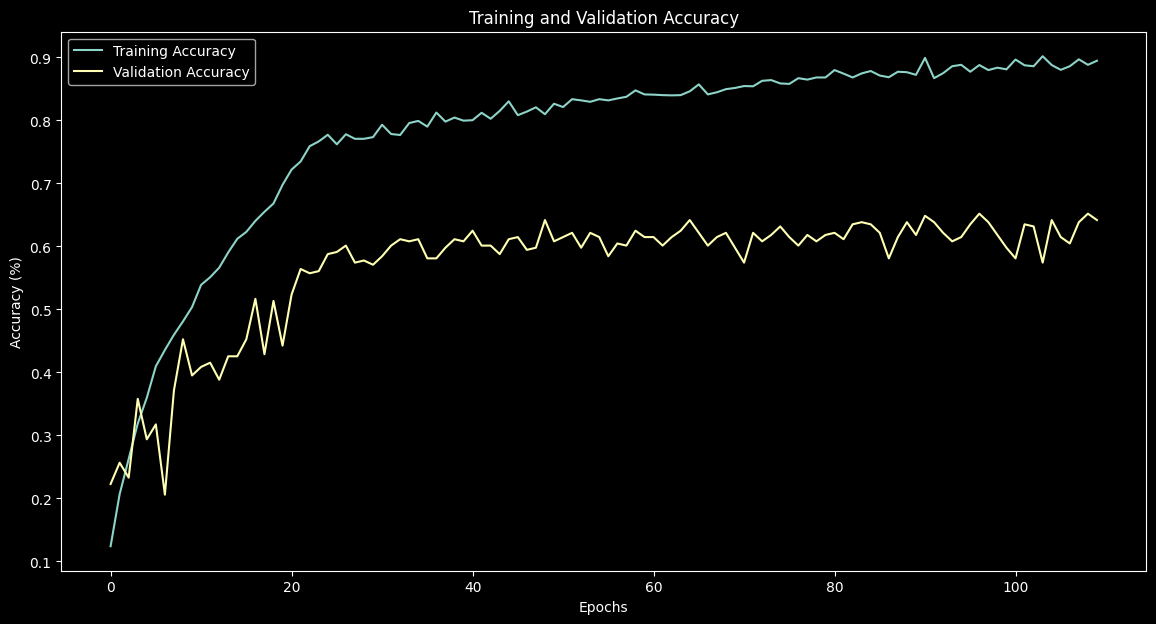

In [30]:
report_metrics(total_train_acc, total_val_acc)

In [31]:
torch.save(test_net.state_dict(), 'TestNet2_652.pth')

It seems that by increasing the number of parameters, we see an increase in the validation accuracy as well. However, the effect of this increase is slowed more and more, meaning that to get small increases in the accuracy, we need to increase the parameter more and more. 

In conclusion:
LightNet 1.7 M: 62.5%
TestNet 3.0 M: 64.8%
TestNet2 4.5 M: 65.2%

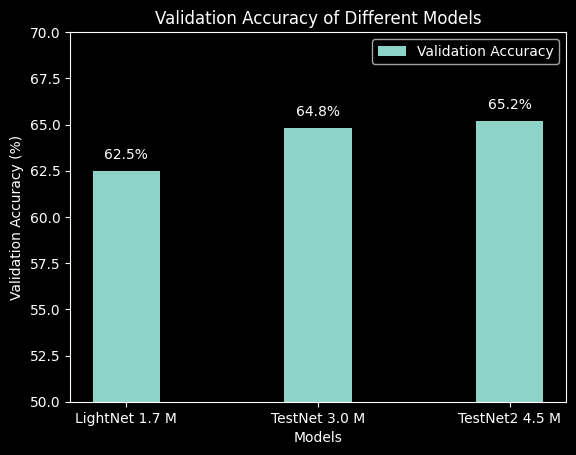

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bar chart
labels = ['LightNet 1.7 M', 'TestNet 3.0 M', 'TestNet2 4.5 M']
sizes = [62.5, 64.8, 65.2]

# Create a bar chart
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(labels))

# Plot the bars
bars = ax.bar(index, sizes, bar_width, label='Validation Accuracy')

# Annotate the values
for i in range(len(sizes)):
    ax.text(index[i], sizes[i] + 0.5, f'{sizes[i]:.1f}%', ha='center', va='bottom')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Validation Accuracy of Different Models')
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.set_ylim(50, 70)  # Set y-axis from 0 to 100
ax.legend()

# Display the bar chart
plt.show()


In [137]:
def visualize_predictions(model, val_dataloader):
    # Set the model to evaluation mode
    model.eval()

    # Get a batch of validation data
    data_iter = iter(val_dataloader)
    images, labels = next(data_iter)

    # Take 10 random images
    indices = np.random.choice(len(images), 10, replace=False)
    sample_images = images[indices]
    sample_labels = labels[indices]

    # Move the images to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sample_images = sample_images.to(device)

    # Getting predictions
    with torch.no_grad():
        outputs = model(sample_images)
        _, preds = torch.max(outputs, 1)

    # Moving the images and predictions back to CPU for plotting
    sample_images = sample_images.cpu()
    preds = preds.cpu()

    # Loading class names from the CSV file
    import csv
    class_names = []
    with open('GroceryStoreDataset/dataset/classes.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader) 
        for row in reader:
            if row[2] not in class_names:
                class_names.append(row[2])  # Assuming the class name is in the 3rd column


    # Plot the images and predicted labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for img, pred, ax in zip(sample_images, preds, axes):
        img = img.permute(1, 2, 0)  # Changing from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.2350, 0.2108, 0.1837]) + torch.tensor([0.5045, 0.3970, 0.2805])  # Unnormalize
        img = img.numpy()
        ax.imshow(img)
        ax.set_title(f'Pred: {class_names[pred]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


Let's see how the model predicts some of the validation images!

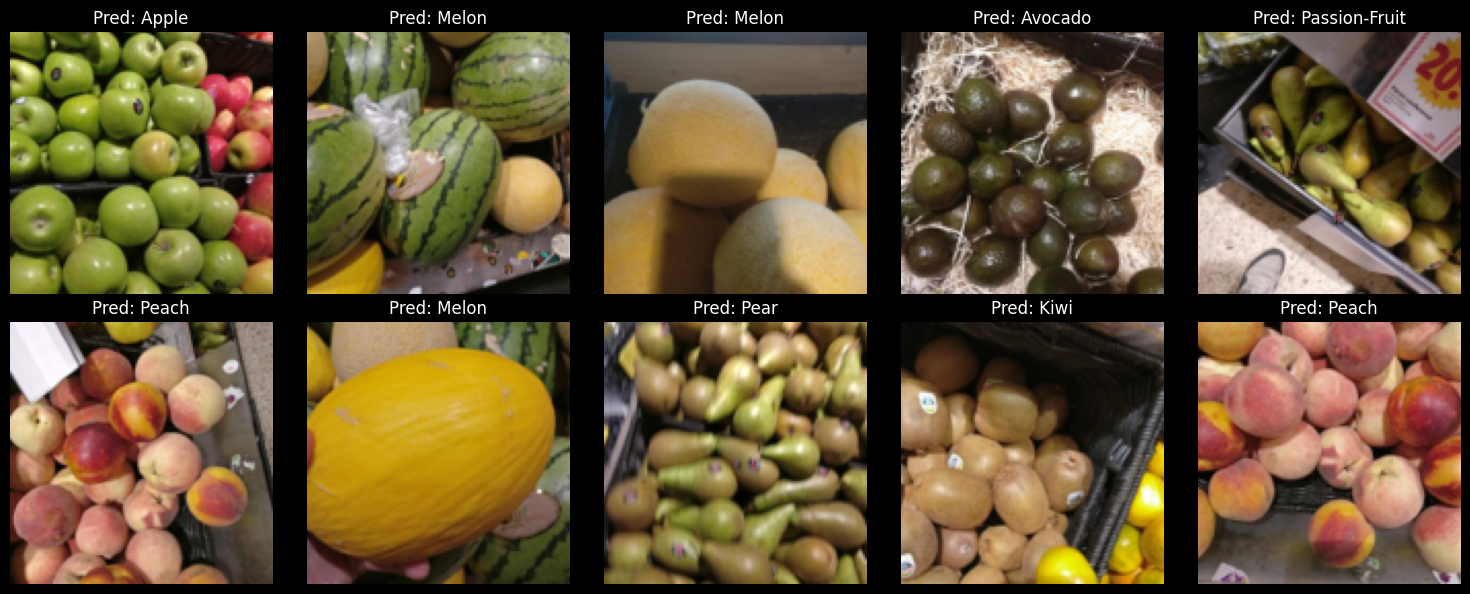

In [139]:
visualize_predictions(test_net2, val_dataloader)

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [71]:
transform_train_ft = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.5502, 0.4297, 0.2988], std=[0.2297, 0.2060, 0.1744])
    ])

transform_val_ft = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5045, 0.3970, 0.2805], std=[0.2350, 0.2108, 0.1837])
    ])

# Create Datasets
train_dataset_ft = GroceryStoreDataset(split='train', transform=transform_train_ft)
val_dataset_ft = GroceryStoreDataset(split='val', transform=transform_val_ft)

# Create DataLoaders
train_dataloader_ft = DataLoader(train_dataset_ft, batch_size=32, shuffle=True)
val_dataloader_ft = DataLoader(val_dataset_ft, batch_size=128, shuffle=False)

In [ ]:
compute_mean_std(val_dataloader_ft)

We modify the resnet18 model for our data by replacing the final layer (fully connected) with our desired layer with `43` outputs.
We will follow the instructions on these two blog posts as a general guidline for fine-tuning.

https://alirezasamar.com/blog/2023/03/fine-tuning-pre-trained-resnet-18-model-image-classification-pytorch/

https://medium.com/@kirudang/deep-learning-computer-vision-using-transfer-learning-resnet-18-in-pytorch-skin-cancer-8d5b158893c5

In [147]:
from torchvision import datasets, models
import torch.optim as optim

# Loading the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, train_dataset.get_num_classes())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

summary(model, (3,224,224))

d:\codebox\virtual_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\codebox\virtual_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [81]:
# Optimizer, loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
num_epochs = 20
model, train_loss, val_loss, train_acc, val_acc = train_model(model, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.003)
num_epochs = 20
model, train_loss, val_loss, train_acc, val_acc = train_model(model, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.005)
num_epochs = 20
model, train_loss, val_loss, train_acc, val_acc = train_model(model, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)



Epoch [1/20], Batch [0/83], Loss: 4.2075, Accuracy: 0.0000
Epoch [1/20], Batch [10/83], Loss: 3.5094, Accuracy: 0.1477
Epoch [1/20], Batch [20/83], Loss: 3.1847, Accuracy: 0.2217
Epoch [1/20], Batch [30/83], Loss: 2.9714, Accuracy: 0.2621
Epoch [1/20], Batch [40/83], Loss: 2.8047, Accuracy: 0.3026
Epoch [1/20], Batch [50/83], Loss: 2.6518, Accuracy: 0.3413
Epoch [1/20], Batch [60/83], Loss: 2.5229, Accuracy: 0.3699
Epoch [1/20], Batch [70/83], Loss: 2.4095, Accuracy: 0.3939
Epoch [1/20], Batch [80/83], Loss: 2.3009, Accuracy: 0.4244
Epoch [1/20] Train Loss: 2.2913, Train Acc: 0.4269, Val Loss: 2.0423, Val Acc: 0.4088
Epoch [2/20], Batch [0/83], Loss: 1.4576, Accuracy: 0.6250
Epoch [2/20], Batch [10/83], Loss: 1.3228, Accuracy: 0.6676
Epoch [2/20], Batch [20/83], Loss: 1.2377, Accuracy: 0.7024
Epoch [2/20], Batch [30/83], Loss: 1.2119, Accuracy: 0.7016
Epoch [2/20], Batch [40/83], Loss: 1.1660, Accuracy: 0.7203
Epoch [2/20], Batch [50/83], Loss: 1.1124, Accuracy: 0.7439
Epoch [2/20], Ba

## BEST val acc so far: 77%

We can clearly see we cannot use the training parameters of the first part, for fine-tuning. 

### Changing optimizer
It seems that the SGD optimizer is not a good choice for fine-tuning. We will experiment with Adam optimizer.

In [148]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.004)
num_epochs = 30
model, train_loss, val_loss, train_acc, val_acc = train_model(model, loss_fn, optimizer,
                                                            train_dataloader, val_dataloader, 
                                                            num_epochs=num_epochs)

Epoch [1/30], Batch [0/83], Loss: 4.0065, Accuracy: 0.0312
Epoch [1/30], Batch [10/83], Loss: 3.5001, Accuracy: 0.1477
Epoch [1/30], Batch [20/83], Loss: 3.1406, Accuracy: 0.2426
Epoch [1/30], Batch [30/83], Loss: 2.7920, Accuracy: 0.3317
Epoch [1/30], Batch [40/83], Loss: 2.5106, Accuracy: 0.3986
Epoch [1/30], Batch [50/83], Loss: 2.3227, Accuracy: 0.4381
Epoch [1/30], Batch [60/83], Loss: 2.1490, Accuracy: 0.4800
Epoch [1/30], Batch [70/83], Loss: 2.0032, Accuracy: 0.5158
Epoch [1/30], Batch [80/83], Loss: 1.8869, Accuracy: 0.5428
Epoch [1/30] Train Loss: 1.8677, Train Acc: 0.5477, Val Loss: 1.4580, Val Acc: 0.6419
Epoch [2/30], Batch [0/83], Loss: 0.9771, Accuracy: 0.8438
Epoch [2/30], Batch [10/83], Loss: 0.7594, Accuracy: 0.8693
Epoch [2/30], Batch [20/83], Loss: 0.6940, Accuracy: 0.8720
Epoch [2/30], Batch [30/83], Loss: 0.6351, Accuracy: 0.8810
Epoch [2/30], Batch [40/83], Loss: 0.6002, Accuracy: 0.8841
Epoch [2/30], Batch [50/83], Loss: 0.5728, Accuracy: 0.8891
Epoch [2/30], Ba

Best Validation Score: 0.8209459459459459


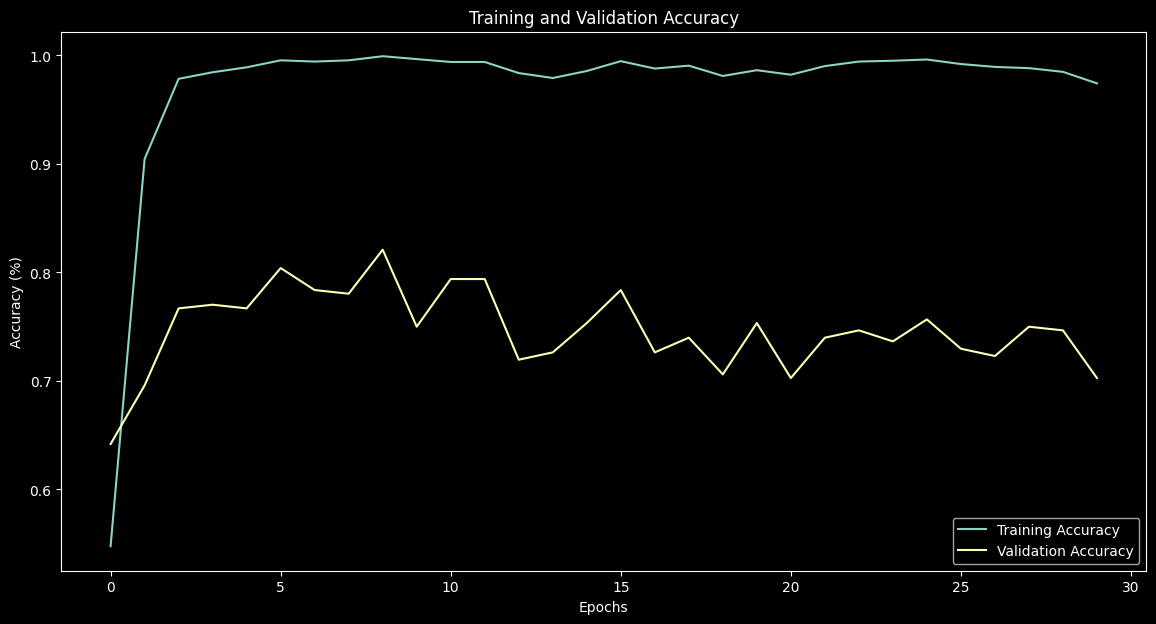

In [149]:
report_metrics(train_acc, val_acc)

Now that we have achieved `0.82 val acc`

In [151]:
torch.save(model.state_dict(), 'resnet_82.pth')

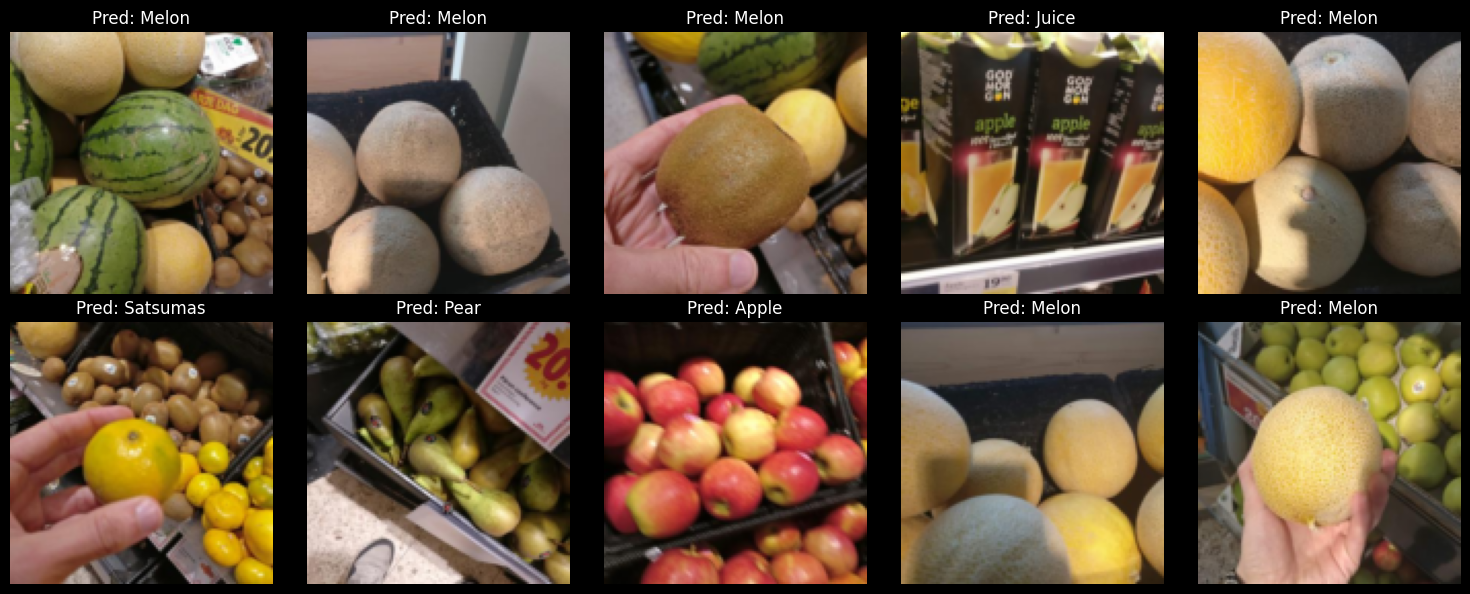

In [150]:
visualize_predictions(model, val_dataloader)